In [1]:
# data manipulation
import pandas as pd
import numpy as np
from google.colab import drive
import pandas_datareader as pdr

# data preprocessing
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.decomposition import PCA

# plotting/visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning/deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Dense, Input, RepeatVector, TimeDistributed,
    Dropout, Activation
)
from keras.layers import Layer
import keras.backend as K
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/ISAN Project/Datasets/data_all.csv')
df.head()

,Date,Ticker,Sector,Open,High,Low,Close,Volume,Dividends,Stock Splits,...,GDP,IndustrialProduction,UnemploymentRate,NonfarmPayments,AvgHourlyEarnings,CorporateProfitsAfterTax,ConsumerLoans,BankLoansAndLeases,SP500Index,USDIndex
0,2021-01-04 00:00:00-05:00,AMC,Communication Services,22.000000,22.000000,20.000000,20.100000,2987380,0.0,0.0,...,22656.793,98.8135,6.4,142913.0,29.92,2716.546,747.3243,10340.3132,3700.65,111.2143
1,2021-01-05 00:00:00-05:00,AMC,Communication Services,19.900000,20.299999,19.100000,19.799999,2814830,0.0,0.0,...,22656.793,98.8135,6.4,142913.0,29.92,2716.546,747.3243,10340.3132,3726.86,110.9649
2,2021-01-06 00:00:00-05:00,AMC,Communication Services,20.299999,22.299999,19.700001,20.100000,6736330,0.0,0.0,...,22656.793,98.8135,6.4,142913.0,29.92,2716.546,747.4342,10337.4329,3748.14,110.8573
3,2021-01-07 00:00:00-05:00,AMC,Communication Services,20.799999,21.100000,20.200001,20.500000,2615050,0.0,0.0,...,22656.793,98.8135,6.4,142913.0,29.92,2716.546,747.4342,10337.4329,3803.79,111.3124
4,2021-01-08 00:00:00-05:00,AMC,Communication Services,20.900000,22.100000,20.700001,21.400000,3955330,0.0,0.0,...,22656.793,98.8135,6.4,142913.0,29.92,2716.546,747.4342,10337.4329,3824.68,111.2930


# Data Cleaning

In [4]:
# create an X dataframe
X = df.copy()

# convert datetime format strings columns to dates
X['Date'] = pd.to_datetime(X['Date'], utc=True).dt.date

In [5]:
"""
Combining the yearly and quarterly metrics

Since the magnitudes for yearly and quarterly aggregates will differ, we will
standardize each feature and combine them.
"""
quarterly_data = [col for col in X.columns if col.endswith('_q')]
yearly_data = [col for col in X.columns if col.endswith('_y')]
new_cols = [col[:-2] for col in quarterly_data]

for col in new_cols:
  # scale each feature
  new_vals = X[[col + '_q', col + '_y']]
  new_col_vals = np.where(np.isnan(new_vals.iloc[:, 0]), new_vals.iloc[:, 1], new_vals.iloc[:, 0])

  # create the new one and drop the old ones
  X.loc[:, col] = new_col_vals
  X.drop(columns=[col + '_q', col + '_y'], inplace=True)

# checking columns
X.columns

Index(['Date', 'Ticker', 'Sector', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Dividends', 'Stock Splits', 'FederalFundsRate', 'PrimeRate',
       '10YrTreasuryRate', 'CPI', 'CoreCPI', 'GDP', 'IndustrialProduction',
       'UnemploymentRate', 'NonfarmPayments', 'AvgHourlyEarnings',
       'CorporateProfitsAfterTax', 'ConsumerLoans', 'BankLoansAndLeases',
       'SP500Index', 'USDIndex', 'TotalRevenue', 'OperatingRevenue',
       'NetIncome', 'NetIncomeCommonStockholders',
       'DilutedNIAvailtoComStockholders', 'DilutedEPS', 'BasicEPS',
       'DilutedAverageShares', 'BasicAverageShares', 'PretaxIncome',
       'TaxProvision', 'NormalizedIncome', 'NetIncomeContinuousOperations',
       'TotalDebt', 'TangibleBookValue', 'InvestedCapital',
       'NetTangibleAssets', 'CommonStockEquity', 'StockholdersEquity',
       'RetainedEarnings', 'CapitalStock', 'CommonStock',
       'TotalLiabilitiesNetMinorityInterest', 'PayablesAndAccruedExpenses',
       'TotalAssets', 'NetPPE', 'CashAn

In [6]:
# get count of rows with null values
X.isnull().sum().where(lambda x: x > 0).dropna().sort_values(ascending=False)

,0
PrimeRate,8730.0
PayablesAndAccruedExpenses,1005.0
RetainedEarnings,755.0
BasicEPS,627.0
DilutedEPS,627.0
DilutedAverageShares,627.0
BasicAverageShares,627.0
InvestedCapital,504.0
NetTangibleAssets,504.0
TotalDebt,504.0


In [7]:
# count of dates where nulls occur vs. count of all dates
print(len(X[X.isna().any(axis=1)]['Date'].unique()))
print(len(X['Date'].unique()))

888
1088


In [8]:
# sorted columns with null values
X.isna().sum().sort_values(ascending=False).where(lambda x: x > 0).dropna()

,0
PrimeRate,8730.0
PayablesAndAccruedExpenses,1005.0
RetainedEarnings,755.0
DilutedAverageShares,627.0
BasicAverageShares,627.0
DilutedEPS,627.0
BasicEPS,627.0
TotalAssets,504.0
TotalLiabilitiesNetMinorityInterest,504.0
StockholdersEquity,504.0


In [9]:
# get FRED data for prime rate
min_date = X[X[['Date', 'PrimeRate']].isna().any(axis=1)]['Date'].min()
max_date = X[X[['Date', 'PrimeRate']].isna().any(axis=1)]['Date'].max()

# print missing min and max dates
print(min_date, max_date)

# get data frame pdr
prime = pdr.DataReader('PRIME', 'fred', min_date, max_date)
prime.columns = ['PrimeRate']

prime.shape

2020-10-01 2022-03-16


(0, 1)

In [10]:
"""
It seems like data does not exist for this date range in pdr.
After researching, it looks like the prime rate was 3.25 for the entire range.
"""

# check for any nulls in prime rate
X['PrimeRate'] = X['PrimeRate'].fillna(3.25)
X['PrimeRate'].isna().sum()

np.int64(0)

In [11]:
# find which subset is missing for the 504
cols_w_504_nan = X.isna().sum() \
  .where(lambda x: x == 504) \
  .dropna() \
  .index.tolist()

print(cols_w_504_nan)

# get date range
dates = X.loc[X[cols_w_504_nan].isna().any(axis=1)]['Date']
print(dates.min(), dates.max())

# get distinct set of tickers
tickers = X.loc[X[cols_w_504_nan].isna().any(axis=1)]['Ticker']
print(tickers.unique())

['TotalDebt', 'TangibleBookValue', 'InvestedCapital', 'NetTangibleAssets', 'CommonStockEquity', 'StockholdersEquity', 'CapitalStock', 'CommonStock', 'TotalLiabilitiesNetMinorityInterest', 'TotalAssets', 'NetPPE', 'CashAndCashEquivalents']
2021-01-04 2021-12-31
['XOM' 'GS']


In [12]:
# drop these XOM/GS stocks between this date range
i_to_drop = X.loc[X['Ticker'].isin(tickers) & X['Date'].isin(dates)].index

X.drop(index=i_to_drop, inplace=True)
X.reset_index(drop=True, inplace=True)

In [13]:
# find which subset is missing for the 627
cols_w_627_nan = X.isna().sum() \
  .where(lambda x: x == 627) \
  .dropna() \
  .index.tolist()

print(cols_w_627_nan)

# get date range
dates = X.loc[X[cols_w_627_nan].isna().any(axis=1)]['Date']
print(dates.min(), dates.max())

# get distinct set of tickers
tickers = X.loc[X[cols_w_627_nan].isna().any(axis=1)]['Ticker']
print(tickers.unique())

['DilutedEPS', 'BasicEPS', 'DilutedAverageShares', 'BasicAverageShares']
2024-10-01 2025-01-30
['LIN' 'KO' 'GOOGL' 'HD' 'PFE' 'DUK' 'TSLA' 'VZ' 'PLD' 'AMZN']


In [14]:
# drop these instances - we do not need information for this date range,
# as it is not available yet via the API
i_to_drop = X.loc[X['Date'].isin(dates)].index

X.drop(index=i_to_drop, inplace=True)
X.reset_index(drop=True, inplace=True)

In [15]:
# payables and accured expenses
dates = X.loc[X[['Date', 'PayablesAndAccruedExpenses']].isna().any(axis=1)]['Date']
print(dates.min(), dates.max())

tickers = X.loc[X[['Date', 'PayablesAndAccruedExpenses']].isna().any(axis=1)]['Ticker']
print(tickers.unique())

# drop for this stock in this date range
i_to_drop = X.loc[X['Ticker'].isin(tickers) & X['Date'].isin(dates)].index

X.drop(index=i_to_drop, inplace=True)
X.reset_index(drop=True, inplace=True)

2023-01-03 2024-09-30
['BAC']


In [16]:
# retained earnings
dates = X.loc[X[['Date', 'RetainedEarnings']].isna().any(axis=1)]['Date']
print(dates.min(), dates.max())

tickers = X.loc[X[['Date', 'RetainedEarnings']].isna().any(axis=1)]['Ticker']
print(tickers.unique())

# drop for this stock in this date range
i_to_drop = X.loc[X['Ticker'].isin(tickers) & X['Date'].isin(dates)].index

X.drop(index=i_to_drop, inplace=True)
X.reset_index(drop=True, inplace=True)

2024-01-02 2024-09-30
['JNJ']


In [17]:
X.isna().sum().sum()

np.int64(0)

In [18]:
X.shape

(28654, 52)

# Feature engineering and standardization

In [19]:
# normalize/standardize columns
num_cols = X.select_dtypes(include='number').columns

# we picked robust scaler due to right-tailed nature of price data
scaler = RobustScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [20]:
# define response variable (close price) and remove highly correlated attributes
y = X['Close']
X.drop(columns=['Close', 'Open', 'High', 'Low'], inplace=True)

# Using PCA to reduce dimensionality

In [21]:
"""
Using PCA to reduce dimensionality
"""
# creating dataset with only numerical attributes for PCA
X_num = X.select_dtypes(include='number')

# conduct PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_num)

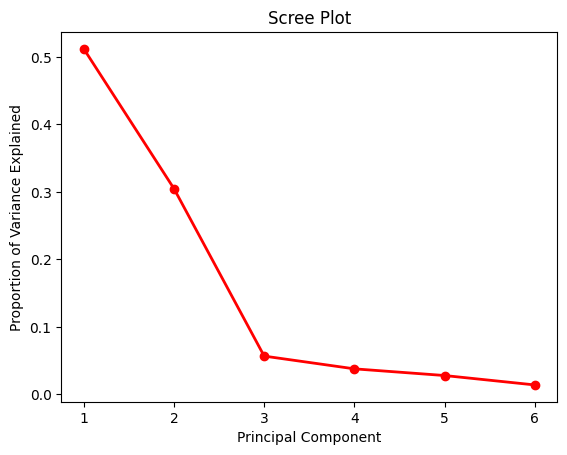

In [22]:
# scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)

plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')

plt.show()

In [23]:
# getting the eigenvectors into a dataframe
eigenvectors_df = pd.DataFrame(
    data=pca.components_.T,
    columns=[f"P{i}" for i in range(1, pca.n_components_ + 1)],
    index=X_num.columns
)

# print eigenvalue for each principal component
print(pca.explained_variance_)

# print cumulative sum of explained variance ratio (we will extract until 0.8)
print(np.cumsum(pca.explained_variance_ratio_))

# print eigenvectors
eigenvectors_df.head()

[91.95035186 54.73706145 10.15478877  6.76382704  4.98360579  2.48050511]
[0.51197753 0.81675228 0.87329392 0.91095476 0.93870337 0.95251477]


,P1,P2,P3,P4,P5,P6
Volume,-0.007621,0.040093,0.926077,-0.108061,0.066166,-0.106228
Dividends,0.000077,-0.000371,-0.001049,0.000126,-0.001093,-0.001915
Stock Splits,0.000021,0.000170,0.000763,-0.000011,-0.000569,0.001603
FederalFundsRate,-0.002086,0.000158,-0.000455,-0.098980,-0.122245,-0.010886
PrimeRate,-0.002083,0.000154,-0.000457,-0.098808,-0.121967,-0.010835


In [24]:
# number of components and index when cumsum reaches 0.8
n_pcs= pca.components_.shape[0]
threshold_index = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0] + 1

# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(threshold_index)]

# get feature names that influence the principal components the most
most_important_names = [X.columns[most_important[i]] for i in range(threshold_index)]

for i in range(threshold_index):
  print('PC{}: {}'.format(i + 1, most_important_names[i]))

PC1: PayablesAndAccruedExpenses
PC2: StockholdersEquity
PC3: Date
PC4: SP500Index
PC5: CoreCPI
PC6: SP500Index


# Creating final training dataset

In [25]:
# combine variables and principal components
df_final = pd.concat([
    X[['Date', 'Ticker', 'Sector']],
    pd.DataFrame(
        X_pca,
        columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)]
    ),
    y
], axis=1)

# verify shapes of X and y are compatible
print(df_final.shape, y.shape)

(28654, 10) (28654,)


In [26]:
df_final.head()

,Date,Ticker,Sector,PC1,PC2,PC3,PC4,PC5,PC6,Close
0,2021-01-04,AMC,Communication Services,-5.505606,-1.818654,-1.223541,0.857447,6.446029,1.510964,-0.585921
1,2021-01-05,AMC,Communication Services,-5.505592,-1.818956,-1.230224,0.856242,6.449773,1.515877,-0.587640
2,2021-01-06,AMC,Communication Services,-5.506768,-1.813064,-1.094167,0.837209,6.460657,1.503236,-0.585921
3,2021-01-07,AMC,Communication Services,-5.505951,-1.819224,-1.238742,0.831946,6.433286,1.524149,-0.583629
4,2021-01-08,AMC,Communication Services,-5.506416,-1.817210,-1.192533,0.821708,6.435215,1.521338,-0.578472


# LSTM Model

In [27]:
def create_train_test_data(df, ticker, train_size):
  df = df[df['Ticker'] == ticker].copy()
  df.reset_index(drop=True, inplace=True)

  df.sort_values('Date', ascending=False)
  df.drop(columns=['Ticker', 'Sector', 'Date'], inplace=True)

  train_df = df.iloc[:int(len(df) * train_size)]
  test_df = df.iloc[int(len(df) * train_size):]

  return train_df, test_df

def create_sequences(df, offset):
  X, y = [], []

  for i in range(offset, len(df)):
    X.append(df.iloc[i-offset:i, 0:-1])
    y.append(df.iloc[i, -1])

  return np.array(X), np.array(y)

In [28]:
"""
Code from:
https://datasciencedojo.com/blog/how-do-i-make-an-lstm-model-with-multiple-inputs/
"""

class AttentionLayer(Layer):
  def __init__(self, **kwargs):
    super(AttentionLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    self.w = self.add_weight(name="att_weight", shape=(input_shape[-1],1),
							 initializer="zeros", trainable=True)
    self.b = self.add_weight(name="att_bias", shape=(1,),  # Add bias
                                initializer="zeros", trainable=True)
    super(AttentionLayer, self).build(input_shape)

  def call(self, x):
    #Attention scores
    e = tf.math.tanh(tf.tensordot(x, self.w, axes=1) + self.b)
    a = tf.nn.softmax(e, axis=1)

    #Apply attention to the input sequence
    output = x*a
    return tf.reduce_sum(output, axis=1)

  def compute_output_shape(self, input_shape):
    return (input_shape[0], input_shape[-1]) # Output shape is (batch_size, feature_dim)

In [29]:
def build_attention_lstm(input_shape):
  inputs = Input(shape=input_shape)
  lstm_out = LSTM(64, return_sequences=True)(inputs) # Keep return_sequences=True for attention

  attention = AttentionLayer()(lstm_out)
  dense = Dense(1)(attention) # Final prediction

  model = Model(inputs, dense)
  model.compile(optimizer="adam", loss="mean_squared_error")

  return model

In [30]:
train_df, test_df = create_train_test_data(df_final, 'AAPL', 0.8)

print(f"Train shape: {train_df.shape}, test shape: {test_df.shape}")

X_train, y_train = create_sequences(train_df, 3)
X_test, y_test = create_sequences(test_df, 3)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Build and summarize the model
model = build_attention_lstm((X_train.shape[1], X_train.shape[2]))
model.summary()

Train shape: (804, 7), test shape: (201, 7)
X_train shape: (801, 3, 6), y_train shape: (801,)
X_test shape: (198, 3, 6), y_test shape: (198,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3, 64)          │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 64)             │            65 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,306 (71.51 KB)

 Trainable params: 18,306 (71.51 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the model
history = model.fit(
	X_train,
	y_train,
	epochs=120,
	batch_size=240,
	validation_data=(X_test, y_test),
	verbose=1
)

Epoch 1/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 0.3396 - val_loss: 0.4790
Epoch 2/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0617 - val_loss: 0.2043
Epoch 3/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0299 - val_loss: 0.0957
Epoch 4/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0558 - val_loss: 0.0717
Epoch 5/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0370 - val_loss: 0.0784
Epoch 6/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0125 - val_loss: 0.0883
Epoch 7/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0099 - val_loss: 0.0829
Epoch 8/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0147 - val_loss: 0.0613
Epoch 9/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0121 - val_loss: 0.0372
Epoch 10/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0072 - val_loss: 0.0226
Epoch 11/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0066 - val_loss: 0.0176
Epoch 12/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0075 - val_l

In [32]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test, verbose=0)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

print(f"Test loss: {test_loss}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Test loss: 0.019947487860918045


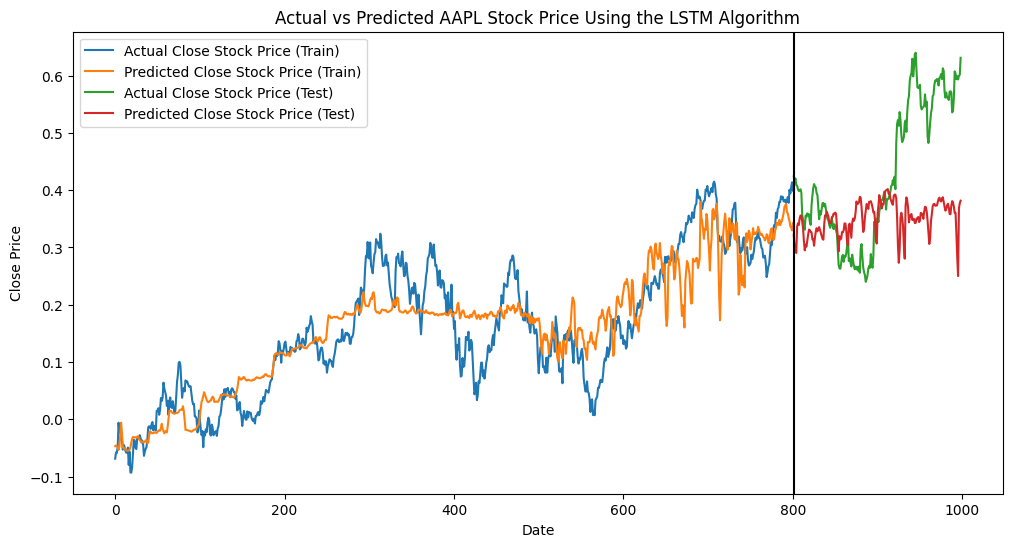

In [33]:
# x axis offset logic
offset = len(y_train)
x_bounds_train = range(offset)
x_bounds_test = range(offset, offset + len(y_test))

# initialize plot
plt.figure(figsize=(12, 6))

# plot training and testing actual vs. predictions
plt.plot(x_bounds_train, y_train, label='Actual Close Stock Price (Train)')
plt.plot(x_bounds_train, y_train_pred, label='Predicted Close Stock Price (Train)')
plt.plot(x_bounds_test, y_test, label='Actual Close Stock Price (Test)')
plt.plot(x_bounds_test, y_pred, label='Predicted Close Stock Price (Test)')

# create line to separate train and test predicions
plt.axvline(x = offset, color = 'black')

# titles
plt.title('Actual vs Predicted AAPL Stock Price Using the LSTM Algorithm')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

plt.show()

# Trying with different stocks

Train shape: (752, 7), test shape: (189, 7)
X_train shape: (749, 3, 6), y_train shape: (749,)
X_test shape: (186, 3, 6), y_test shape: (186,)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 3, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 3, 64)          │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_4               │ (None, 64)             │            65 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,306 (71.51 KB)

 Trainable params: 18,306 (71.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.4602 - val_loss: 0.0277
Epoch 2/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2300 - val_loss: 0.0539
Epoch 3/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1261 - val_loss: 0.0929
Epoch 4/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1126 - val_loss: 0.0990
Epoch 5/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1092 - val_loss: 0.0742
Epoch 6/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0923 - val_loss: 0.0501
Epoch 7/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0844 - val_loss: 0.0396
Epoch 8/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0800 - val_loss: 0.0389
Epoch 9/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0782 - val_loss: 0.0428
Epoch 10/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0775 - val_loss: 0.0536
Epoch 11/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0769 - val_loss: 0.0706
Epoch 12/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0747 - val_l

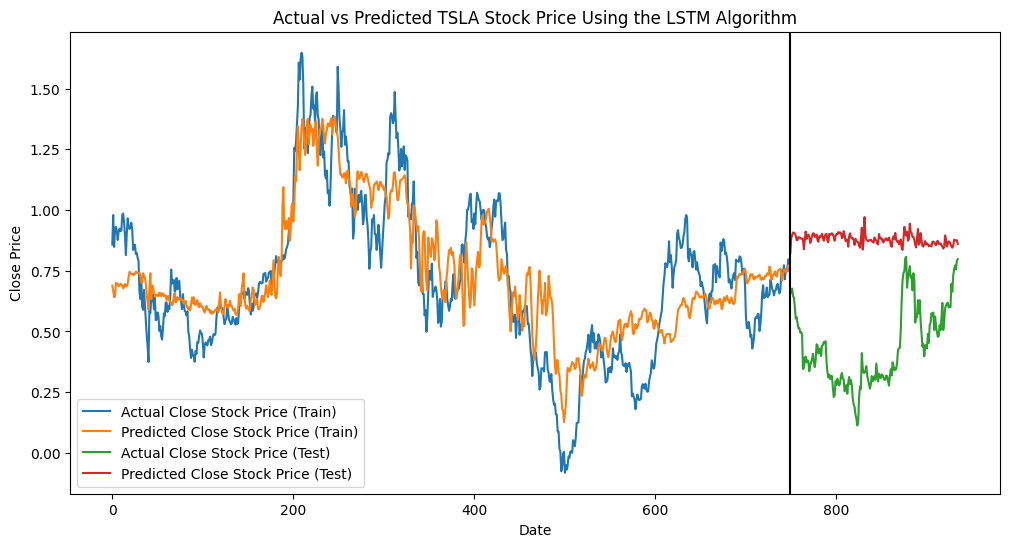

{'Ticker': 'TSLA',
 'Train MAE': 0.14297583397366068,
 'Train MSE': 0.030720210599130746,
 'Train R2': 0.6983612993477066,
 'Test MAE': 0.43924590878366193,
 'Test MSE': 0.21967635705001196,
 'Test R2': -7.469120424068951}

In [38]:
"""
Creating the model
"""
def build_attention_lstm(input_shape):
  # input layer
  inputs = Input(shape=input_shape)

  # LSTM layer
  lstm_out = LSTM(64, return_sequences=True)(inputs)

  # attention layer
  attention = AttentionLayer()(lstm_out)
  dense = Dense(1)(attention) # Final prediction

  model = Model(inputs, dense)
  model.compile(optimizer="adam", loss="mean_squared_error")

  return model


"""
Creating a function to parameterize per symbol
"""
def create_model(ticker, lag, epochs, batch_size):
  results_dict = {}
  results_dict['Ticker'] = ticker

  train_df, test_df = create_train_test_data(df_final, ticker, 0.8)

  print(f"Train shape: {train_df.shape}, test shape: {test_df.shape}")

  X_train, y_train = create_sequences(train_df, lag)
  X_test, y_test = create_sequences(test_df, lag)

  print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
  print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

  # Build and summarize the model
  model = build_attention_lstm((X_train.shape[1], X_train.shape[2]))
  model.summary()

  # Train the model
  history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=1
  )

  # Evaluate the model
  test_loss = model.evaluate(X_test, y_test, verbose=0)
  y_train_pred = model.predict(X_train)
  y_pred = model.predict(X_test)

  print(f"Test loss: {test_loss}")

  # Calculate MAE, MSE, RMSE, and R-squared
  results_dict['Train MAE'] = mean_absolute_error(y_train, y_train_pred)
  results_dict['Train MSE'] = mean_squared_error(y_train, y_train_pred)
  results_dict['Train R2'] = r2_score(y_train, y_train_pred)

  results_dict['Test MAE'] = mean_absolute_error(y_test, y_pred)
  results_dict['Test MSE'] = mean_squared_error(y_test, y_pred)
  results_dict['Test R2'] = r2_score(y_test, y_pred)

  # x axis offset logic
  offset = len(y_train)
  x_bounds_train = range(offset)
  x_bounds_test = range(offset, offset + len(y_test))

  # initialize plot
  plt.figure(figsize=(12, 6))

  # plot training and testing actual vs. predictions
  plt.plot(x_bounds_train, y_train, label='Actual Close Stock Price (Train)')
  plt.plot(x_bounds_train, y_train_pred, label='Predicted Close Stock Price (Train)')
  plt.plot(x_bounds_test, y_test, label='Actual Close Stock Price (Test)')
  plt.plot(x_bounds_test, y_pred, label='Predicted Close Stock Price (Test)')

  # create line to separate train and test predicions
  plt.axvline(x = offset, color = 'black')

  # titles
  plt.title(f'Actual vs Predicted {ticker} Stock Price Using the LSTM Algorithm')
  plt.xlabel('Date')
  plt.ylabel('Close Price')
  plt.legend()

  plt.show()

  return results_dict

# predict with sample stock
create_model('TSLA', 3, 120, 240)

Train shape: (752, 7), test shape: (189, 7)
X_train shape: (749, 3, 6), y_train shape: (749,)
X_test shape: (186, 3, 6), y_test shape: (186,)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 3, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 3, 64)          │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_5               │ (None, 64)             │            65 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,306 (71.51 KB)

 Trainable params: 18,306 (71.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.5908 - val_loss: 0.2905
Epoch 2/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4876 - val_loss: 0.1481
Epoch 3/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4345 - val_loss: 0.0575
Epoch 4/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4135 - val_loss: 0.0168
Epoch 5/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3886 - val_loss: 0.0066
Epoch 6/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3656 - val_loss: 0.0045
Epoch 7/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3498 - val_loss: 0.0048
Epoch 8/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3475 - val_loss: 0.0049
Epoch 9/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3136 - val_loss: 0.0089
Epoch 10/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3223 - val_loss: 0.0095
Epoch 11/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3189 - val_loss: 0.0093
Epoch 12/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2840 - val_l

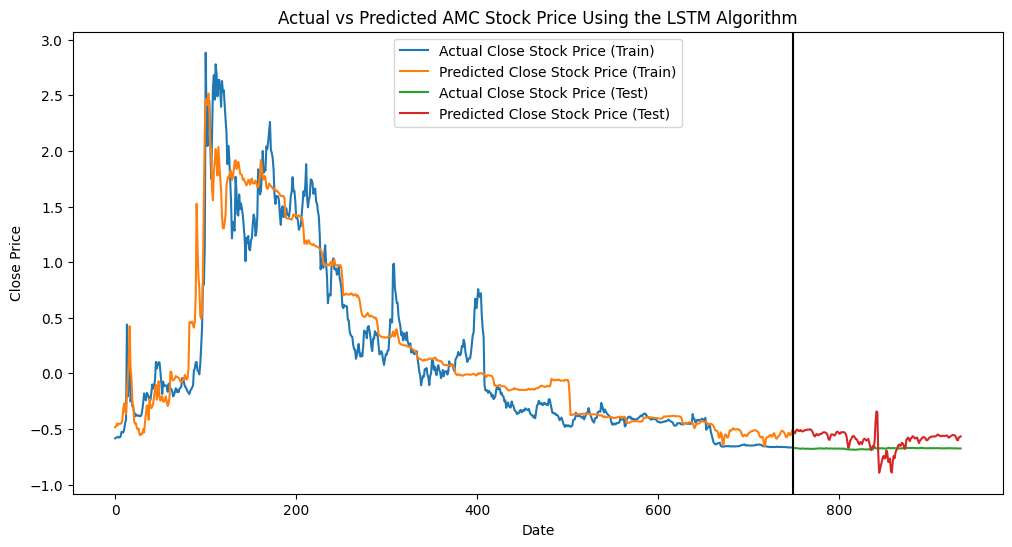

{'Ticker': 'AMC',
 'Train MAE': 0.18216311980390734,
 'Train MSE': 0.07229756489194535,
 'Train R2': 0.8927358973058663,
 'Test MAE': 0.10664451308118873,
 'Test MSE': 0.013880545761623474,
 'Test R2': -761.4566509061021}

In [39]:
# predict with sample stock
create_model('AMC', 3, 120, 240)

Train shape: (752, 7), test shape: (189, 7)
X_train shape: (749, 3, 6), y_train shape: (749,)
X_test shape: (186, 3, 6), y_test shape: (186,)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 3, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 3, 64)          │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_6               │ (None, 64)             │            65 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,306 (71.51 KB)

 Trainable params: 18,306 (71.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - loss: 0.1214 - val_loss: 0.0098
Epoch 2/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0434 - val_loss: 0.0321
Epoch 3/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0228 - val_loss: 0.1264
Epoch 4/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0170 - val_loss: 0.2148
Epoch 5/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0230 - val_loss: 0.1815
Epoch 6/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0174 - val_loss: 0.1222
Epoch 7/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0166 - val_loss: 0.0997
Epoch 8/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0133 - val_loss: 0.0996
Epoch 9/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0121 - val_loss: 0.0902
Epoch 10/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0125 - val_loss: 0.0756
Epoch 11/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0113 - val_loss: 0.0676
Epoch 12/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0114 - val_l

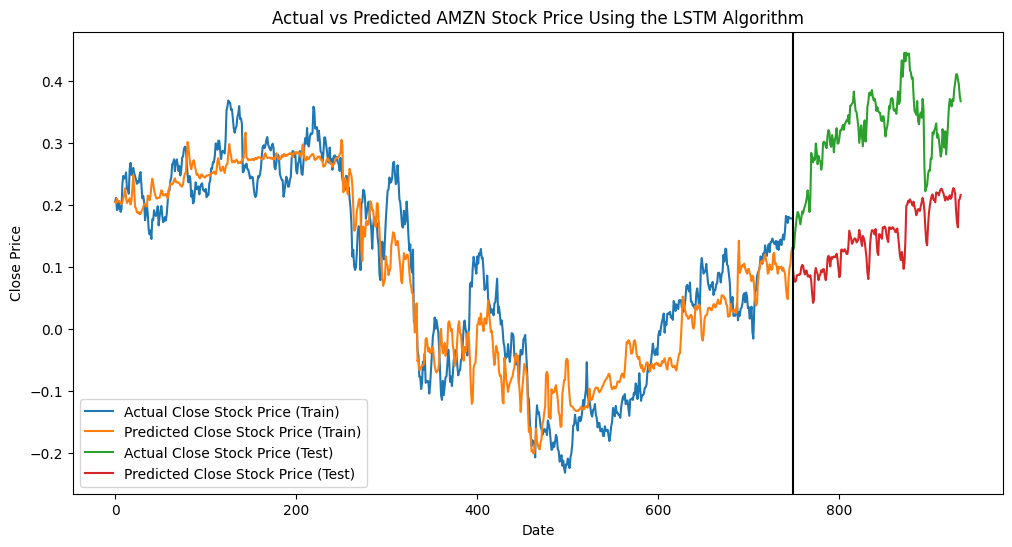

{'Ticker': 'AMZN',
 'Train MAE': 0.046454760895130565,
 'Train MSE': 0.003317664845915195,
 'Train R2': 0.8662180372372981,
 'Test MAE': 0.17282195299634778,
 'Test MSE': 0.033368181319021493,
 'Test R2': -6.922322137985177}

In [40]:
# predict with sample stock
create_model('AMZN', 3, 120, 240)

# Creating a global model

In [37]:
df_global = df_final.copy()

# one hot encode categorical variables
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_cols = enc.fit_transform(df_global[['Ticker','Sector']])

one_hot_df = pd.DataFrame(cat_cols, columns=enc.get_feature_names_out())
df_encoded = pd.concat([df_global, one_hot_df], axis=1)
df_encoded = df_encoded.drop(columns=['Ticker', 'Sector'], axis=1)

# separating out dates
dates = pd.to_datetime(df_encoded['Date'])

df_encoded['Year'] = dates.dt.year
df_encoded['Month'] = dates.dt.month
df_encoded['Day'] = dates.dt.day

df_encoded = df_encoded.drop(columns=['Date'])

df_encoded.head()

,PC1,PC2,PC3,PC4,PC5,PC6,Close,Ticker_AAPL,Ticker_AMC,Ticker_AMT,...,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Utilities,Year,Month,Day
0,-5.505606,-1.818654,-1.223541,0.857447,6.446029,1.510964,-0.585921,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,1,4
1,-5.505592,-1.818956,-1.230224,0.856242,6.449773,1.515877,-0.587640,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,1,5
2,-5.506768,-1.813064,-1.094167,0.837209,6.460657,1.503236,-0.585921,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,1,6
3,-5.505951,-1.819224,-1.238742,0.831946,6.433286,1.524149,-0.583629,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,1,7
4,-5.506416,-1.817210,-1.192533,0.821708,6.435215,1.521338,-0.578472,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,1,8


In [ ]:
# create the train test split
def create_train_test_data(df, ticker, train_size):
  df = df[df[f'Ticker_{ticker}'] == 1].copy()
  df.reset_index(drop=True, inplace=True)

  train_df = df.iloc[:int(len(df) * train_size)]
  test_df = df.iloc[int(len(df) * train_size):]

  return train_df, test_df


# create data sequences for LSTM model
def create_sequences(df, offset):
  X, y = [], []
  X_cols = df.columns[df.columns != 'Close'].tolist()

  for i in range(offset, len(df)):
    X.append(df[X_cols].iloc[i-offset:i, :])
    y.append(df['Close'].iloc[i])

  return np.array(X), np.array(y)


# create dataframe containing all stocks with one-hot-encoding
def create_global_df(offset):
  X_train, X_test, y_train, y_test = [], [], [], []

    # logic for train/test split
  ticker_cols = df_encoded.columns[df_encoded.columns.str.startswith('Ticker')]

  for col in ticker_cols:
    ticker = col[7:]
    train_df, test_df = create_train_test_data(df_encoded, ticker, 0.8)

    X_train_temp, y_train_temp = create_sequences(train_df, offset)
    X_test_temp, y_test_temp = create_sequences(test_df, offset)

    X_train.extend(X_train_temp)
    X_test.extend(X_test_temp)
    y_train.extend(y_train_temp)
    y_test.extend(y_test_temp)

  return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [ ]:
"""
Creating the model
"""
def build_attention_lstm(input_shape):
  # input layer
  inputs = Input(shape=input_shape)

  # LSTM layer
  lstm_out = LSTM(64, return_sequences=True)(inputs)

  # attention layer
  attention = AttentionLayer()(lstm_out)
  dense = Dense(1)(attention) # Final prediction

  model = Model(inputs, dense)
  model.compile(optimizer="adam", loss="mean_squared_error")

  return model


"""
Creating a function to parameterize per symbol
"""
def create_model(X_train, y_train, X_test, y_test, epochs, batch_size):
  # Build and summarize the model
  model = build_attention_lstm((X_train.shape[1], X_train.shape[2]))
  model.summary()

  # Train the model
  history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=1
  )

  # Return model
  return model

In [ ]:
lag = 60

# create train and test data
X_train, y_train, X_test, y_test = create_global_df(lag)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

In [ ]:
# build model
model = create_model(X_train, y_train, X_test, y_test, 120, 240)

In [ ]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test, verbose=0)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

print(f"Test loss: {test_loss}")

In [ ]:
def find_index_with_substring(arr, substring):
  for index, element in enumerate(arr):
    if substring in element:
      return index
  return -1

def get_ticker_results(ticker):
  columns = df_encoded.drop('Close', axis=1).columns
  index = find_index_with_substring(columns, ticker)

  test_filtered_indices = np.where(X_test[:, :, index] == 1)[0]
  train_filtered_indices = np.where(X_train[:, :, index] == 1)[0]

  # Create separate DataFrames and then concatenate
  test_dates = pd.DataFrame()
  train_dates = pd.DataFrame()

  test_y = pd.DataFrame(y_test[test_filtered_indices])
  pred_y = pd.DataFrame(y_pred[test_filtered_indices])

  train_pred_y = pd.DataFrame(y_train_pred[train_filtered_indices])
  train_y = pd.DataFrame(y_train[train_filtered_indices])

  # return values
  return (
      test_y.values.flatten(),
      pred_y.values.flatten(),
      train_pred_y.values.flatten(),
      train_y.values.flatten()
  )

In [ ]:
def plot_stock_results(ticker):
  test_y, pred_y, train_pred_y, train_y = get_ticker_results(ticker)

  # x axis offset logic
  offset = len(train_y)
  x_bounds_train = range(offset)
  x_bounds_test = range(offset, offset + len(test_y))

  # initialize plot
  plt.figure(figsize=(12, 6))

  # plot training and testing actual vs. predictions
  plt.plot(x_bounds_train, train_y, label='Actual Close Stock Price (Train)')
  plt.plot(x_bounds_train, train_pred_y, label='Predicted Close Stock Price (Train)')
  plt.plot(x_bounds_test, test_y, label='Actual Close Stock Price (Test)')
  plt.plot(x_bounds_test, pred_y, label='Predicted Close Stock Price (Test)')

  # create line to separate train and test predicions
  plt.axvline(x = offset, color = 'black')

  # titles
  plt.title(f'Actual vs Predicted {ticker} Stock Price Using the LSTM Algorithm')
  plt.xlabel('Days')
  plt.ylabel('Close Price')
  plt.legend()
  plt.show()

# Evaluating performance of the first model

In [44]:
# using the first model on all the stocks
metrics_data = []

for ticker in df_final['Ticker'].unique():
  try:
    metrics_data.append(create_model(ticker, 3, 120, 240))
  except Exception as e:
    print(e)

Output hidden; open in https://colab.research.google.com to view.

In [50]:
pd.DataFrame(metrics_data).to_csv('/content/gdrive/MyDrive/ISAN Project/Datasets/LSTM_model_metrics.csv', index=False)